In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import classification_report
import seaborn as sns
plt.style.use('ggplot')
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.2


In [4]:
# load the data
df = pd.read_csv('Hotel_Reviews.csv')

# keep only the reviews that are greater than or equal to 8.5 
# or less than or equal to 6.5
df = df.loc[(df.Reviewer_Score>=8.5) | (df.Reviewer_Score<=6.5)].copy()

# create a function for the label

def review_label(x):
    if x>=8.5:
        return 1
    else:
        return 0
    

# create the label column    
df['label'] = df['Reviewer_Score'].apply(lambda x: review_label(x))


# replace the 'No Positive' and the 'No Negative' 
# from the corresponding columns with an empty string

df['Positive_Review'].replace('^No Positive$', '', inplace=True, regex=True)
df['Negative_Review'].replace('^No Negative$', '', inplace=True, regex=True)

# concatenate the Positive and Negative Review columns into 'Reviews'
df['reviews'] = df['Negative_Review'] + df['Positive_Review']

# remove the empty reviews
df = df.loc[df['reviews'].apply(lambda x:len(x.split()))>0]
df = df[['reviews', 'label']].copy()
df.reset_index(drop = True, inplace = True)
df.head(10)

,reviews,label
0,I am so angry that i made this post available...,0
1,My room was dirty and I was afraid to walk ba...,0
2,Cleaner did not change our sheet and duvet ev...,0
3,Apart from the price for the brekfast Everyth...,1
4,Even though the pictures show very clean room...,0
5,Nothing all great Rooms were stunningly deco...,1
6,6 30 AM started big noise workers loading woo...,0
7,The floor in my room was filfy dirty Very bas...,0
8,This hotel is being renovated with great care...,1
9,The staff in the restaurant could of been mor...,1


# New Section

In [5]:
df.shape

(361844, 2)

In [6]:
# undersample the data

df_grouped_by = df.groupby(['label'])
 
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))
 
df_balanced = df_balanced.droplevel(['label'])

# shuffle the data frame
df = df_balanced.sample(frac=1, random_state=1).reset_index(drop=True)
df.head(10) 

,reviews,label
0,There is a night club in the hotel basement a...,1
1,the carpet was not clean it was smelling the ...,0
2,Do not stay here I had a single room I didn t...,0
3,The restaurants do not belong to the hotel Th...,0
4,I tried the buffet restaurant once It was the...,0
5,Could not find anything we did not like Lovel...,1
6,Jibril was briliant Nothing was too much trou...,1
7,The staff were very friendly and helpful Brea...,1
8,nothing excellent location tube station a min...,1
9,3 star reception quality small rooms no lobby...,0


In [7]:
# create the train and test datasets
train = df.sample(frac=0.75, random_state=1)
test = df.drop(train.index)

In [8]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(train['reviews'])
X_test = normalize(test['reviews'])

In [9]:
vocab_size = 10000
embedding_dim = 64
max_length = 256
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [10]:
## tokenizer = Tokenizer(num_words=max_vocab)
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [11]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding=padding_type, truncating=trunc_type, maxlen=max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [17]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, train['label'].values, epochs=10, validation_data=(X_test, test['label'].values), batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
3400/3400 [==============================] - 131s 37ms/step - loss: 0.3417 - accuracy: 0.8418 - val_loss: 0.2639 - val_accuracy: 0.8887
Epoch 2/10
3400/3400 [==============================] - 126s 37ms/step - loss: 0.2511 - accuracy: 0.8952 - val_loss: 0.2544 - val_accuracy: 0.8866
Epoch 3/10
3400/3400 [==============================] - 126s 37ms/step - loss: 0.2292 - accuracy: 0.9043 - val_loss: 0.2526 - val_accuracy: 0.8922
Epoch 4/10
3400/3400 [==============================] - 126s 37ms/step - loss: 0.2164 - accuracy: 0.9102 - val_loss: 0.2512 - val_accuracy: 0.8933
Epoch 5/10
3400/3400 [==============================] - 126s 37ms/step - loss: 0.2075 - accuracy: 0.9141 - val_loss: 0.2576 - val_accuracy: 0.8920
Epoch 6/10
3400/3400 [==============================] - 126s 37ms/step - loss: 0.1988 - accuracy: 0.9183 - val_loss: 0.2647 - val_accuracy: 0.8937
Epoch 7/10
3400/3400 [==============================] - 126s 37ms/step - loss: 0.1905 - accuracy: 0.9223 - val_loss: 0

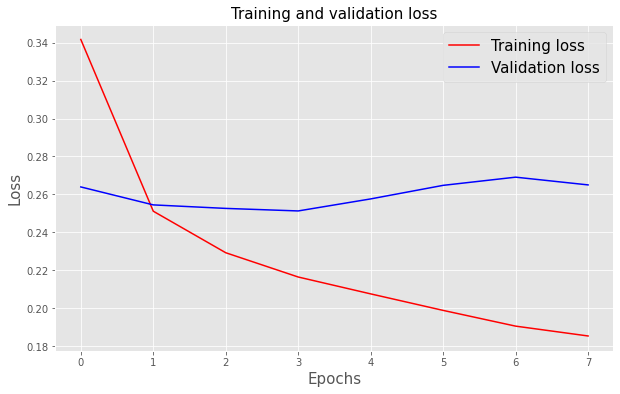

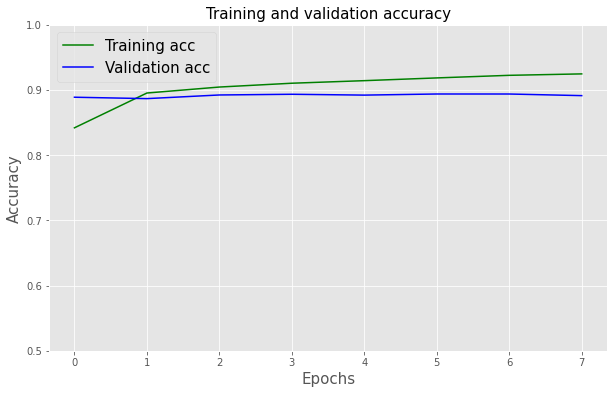

In [18]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [19]:
model.evaluate(X_test, test['label'].values)

1063/1063 [==============================] - 16s 15ms/step - loss: 0.2647 - accuracy: 0.8937


[0.26474496722221375, 0.8936764597892761]

In [20]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [21]:
pred_train = model.predict(X_train)

binary_predictions_train = []

for i in pred_train:
    if i >= 0.5:
        binary_predictions_train.append(1)
    else:
        binary_predictions_train.append(0)

In [22]:
print(classification_report(train['label'], binary_predictions_train))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     50892
           1       0.96      0.89      0.92     51106

    accuracy                           0.93    101998
   macro avg       0.93      0.93      0.93    101998
weighted avg       0.93      0.93      0.93    101998



In [24]:
print(classification_report(test['label'], binary_predictions))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     17107
           1       0.93      0.85      0.89     16893

    accuracy                           0.89     34000
   macro avg       0.90      0.89      0.89     34000
weighted avg       0.90      0.89      0.89     34000



In [25]:
print('Accuracy on testing set:', accuracy_score(binary_predictions,  test['label'].values))
print('Precision on testing set:', precision_score(binary_predictions,  test['label'].values))
print('Recall on testing set:', recall_score(binary_predictions,  test['label'].values))

Accuracy on testing set: 0.8936764705882353
Precision on testing set: 0.8536671994317173
Recall on testing set: 0.9265612952968388


In [26]:
print('Accuracy on training set:', accuracy_score(binary_predictions_train,  train['label'].values))
print('Precision on training set:', precision_score(binary_predictions_train,  train['label'].values))
print('Recall on training set:', recall_score(binary_predictions_train,  train['label'].values))

Accuracy on training set: 0.9268122904370674
Precision on training set: 0.8947090361210034
Recall on training set: 0.9564098809847518


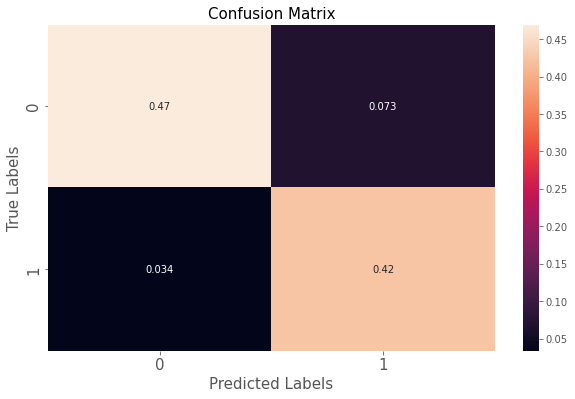

In [27]:
matrix = confusion_matrix(binary_predictions, test['label'].values, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);